# Histogram for Estimating the Best Parameters of Walkable Accessibility Score (WAS)

### Last update: March 3, 2025

#### Goal: Compute a Walkable Accessibility Score (WAS) at the block group scale using InfoUSA POI data and compare it to the official Walkscore

This notebook creates a Walkable Accessibility Score (WAS) computing the distance between businesses (points) and the centroids of block groups (points). The goal is to show through an example how to compute an access metric and to make it accessible enough for practitioners and scholars to use for their own purpose. Thus, businesses could be easily changed with other data of interest, such as schools, parks, or any other data. Also, the polygons (in this case, block groups), can be interchanged with other geographies, such as tracts, blocks or a similar type of geography that you might be interested in.

In this example, we use business data from INFO USA and the geometries of the block groups from [IPUMS NHGIS](https://data2.nhgis.org/).

In [1]:
# Add this cell to time how long it takes to run the notebook

import timeit
start_time = timeit.default_timer()

### 1. Load libraries needed

In [2]:
# Load libraries
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats # for correlation
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import os

In [3]:
import sys  
sys.path.insert(1, '/users/ifarah/appdata/roaming/python/python39/site-packages')

We must specify the correct directory path to load some packages. In the code below, REPLACE 'ifarah' with your personal username. It should be shown in the output directories of the installed packages above.

### 2. Load data

Load data that contain latitude and longitude as columns of the table. These could be points or centroids of polygons.
In this case, we use data from Info USA that is private data. However, you can use any business data you have access to by adding it to the `data` folder.

In [4]:
# Load 2011 InfoUSA data - other data can be used
# Takes ~2 min to run
# df = pd.read_csv('../data/1997_Business_Academic_QCQ.txt', sep=",", encoding='latin-1')
df = pd.read_csv('../data/2011_Business_Academic_QCQ.txt', sep=",", encoding='latin-1')

/var/folders/93/2tplx4tn2jdc1zgf9bm7hmfr0000gn/T/ipykernel_4605/258433860.py:4: DtypeWarning: Columns (24,39,42,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/2011_Business_Academic_QCQ.txt', sep=",", encoding='latin-1')


### 3. Know your data!

#### Check how large is your data and what information it contains.

In [5]:
"Your data contains " + str(len(df)) + " rows."

'Your data contains 13468613 rows.'

The table contains the followning information:

In [6]:
sorted(list(df.columns.values.tolist()))

['ABI',
 'Address Line 1',
 'Address Type Indicator',
 'Archive Version Year',
 'Area Code',
 'Business Status Code',
 'CBSA Code',
 'CBSA Level',
 'CSA Code',
 'Census Block',
 'Census Tract',
 'City',
 'Company',
 'Company Holding Status',
 'County Code',
 'Employee Size (5) - Location',
 'FIPS Code',
 'IDCode',
 'Industry Specific First Byte',
 'Latitude',
 'Location Employee Size Code',
 'Location Sales Volume Code',
 'Longitude',
 'Match Code',
 'NAICS8 Descriptions',
 'Office Size Code',
 'Parent Actual Employee Size',
 'Parent Actual Sales Volume',
 'Parent Employee Size Code',
 'Parent Number',
 'Parent Sales Volume Code',
 'Population Code',
 'Primary NAICS Code',
 'Primary SIC Code',
 'SIC Code',
 'SIC Code 1',
 'SIC Code 2',
 'SIC Code 3',
 'SIC Code 4',
 'SIC6_Descriptions',
 'SIC6_Descriptions (SIC)',
 'SIC6_Descriptions (SIC1)',
 'SIC6_Descriptions(SIC2)',
 'SIC6_Descriptions(SIC3)',
 'SIC6_Descriptions(SIC4)',
 'Sales Volume (9) - Location',
 'Site Number',
 'State',
 'S

### 4. Clean data of interest

#### 4.1. Filter data

Amenities that we select: groceries, restaurants, coffee shops, banks, parks, schools, bookstores, entertainment, and general shopping establishments.

Data from schools comes from the 2011 [Great Schools](https://www.greatschools.org/catalog/pdf/GreatSchools-2011-AR-final.pdf) data and parks of the centroids extracted from open 2021 [ArcGIS data](https://www.arcgis.com/home/item.html?id=f092c20803a047cba81fbf1e30eff0b5).


In [7]:
#Convert the column to string
df['Primary NAICS Code'].astype(str)

#Created new categories of NAICS codes so it is easier to filter the categories of interest.
df['NAICS'] = df['Primary NAICS Code'].astype(str)
df['NAICS2'] = df.NAICS.str[:2]
df['NAICS4'] = df.NAICS.str[:4]
df['NAICS6'] = df.NAICS.str[:6]
df.NAICS4.value_counts()

# Filter by specific amenity NAICS codes
filtered = df.loc[(df['NAICS2'] == '72') | (df['NAICS4'] == '4421') | (df['NAICS4'] == '4431') | (df['NAICS4'] == '4451') | 
                (df['NAICS4'] == '4461') | (df['NAICS4'] == '4481') | (df['NAICS4'] == '4482') | (df['NAICS4'] == '4483') |
                (df['NAICS4'] == '4511') | (df['NAICS4'] == '4531') | (df['NAICS4'] == '4532') | (df['NAICS4'] == '4539') |
                (df['NAICS4'] == '4453') | (df['NAICS4'] == '4523') | (df['NAICS4'] == '5221') | (df['NAICS6'] == '311811') |
                (df['NAICS6'] == '451211')]

# Remove Puerto Rico, Alaska, Hawaii, and US Virgin Islands because we will be measuring distances and islands will affect our analysis
filtered = filtered[(filtered['State'] != 'PR') & (filtered['State'] != 'AK') & (filtered['State'] != 'HI') & (filtered['State'] != 'VI')]

# Making sure that the latitude and longitude include all decimal points. # Is this right?
filtered = filtered[filtered.Longitude != '-000.000-76']
filtered = filtered[filtered.Latitude != '-000.000-76']

### Create Weights

In [8]:
# Mapping values (you can change the assignments as needed)
# Function to assign weights with a default of 1
def assign_weights(type, mapping=None):
    if mapping is None:
        mapping = {}  # Default to empty dict
    return mapping.get(type, 1)  # Return mapped value or default to 1

In [9]:
# Example. Change NAICS2 according to whatever your type of destination values are. In our case, amenities.
filtered['NAICS2'] = filtered['NAICS2'].astype(int)  # Ensure integer type or whatever your category is

#mapping = {72: 1, 44: 2, 45: 0.5, 23: 2, 52:1, 31:2}  # Example mapping for different types of weights
mapping = {} # Defaults the weights to 1

filtered['types_weights'] = filtered['NAICS2'].apply(lambda x: assign_weights(x, mapping))

In [10]:
filtered.head(2)

,Company,Address Line 1,City,State,ZipCode,Zip4,County Code,Area Code,IDCode,Location Employee Size Code,...,Match Code,CBSA Code,CBSA Level,CSA Code,FIPS Code,NAICS,NAICS2,NAICS4,NAICS6,types_weights
101581,AMGARI HOME & GARDEN,127 LEALAND AVE,AGAWAM,MA,1001.0,2413.0,13.0,413,2,A,...,P,44140.0,2.0,521.0,25013.0,45311001.0,45,4531,453110,1
101590,ISTANBUL MEDITERRENEAN GRILL,365 WALNUT STREET EXT,AGAWAM,MA,1001.0,1523.0,13.0,413,2,C,...,P,44140.0,2.0,521.0,25013.0,72251117.0,72,7225,722511,1


#### Check your data...How large is your filtered data and how does it look?

In [11]:
"Your filtered data contains " + str(len(filtered)) + " rows."

'Your filtered data contains 1968832 rows.'

In [12]:
filtered.head(3)

,Company,Address Line 1,City,State,ZipCode,Zip4,County Code,Area Code,IDCode,Location Employee Size Code,...,Match Code,CBSA Code,CBSA Level,CSA Code,FIPS Code,NAICS,NAICS2,NAICS4,NAICS6,types_weights
101581,AMGARI HOME & GARDEN,127 LEALAND AVE,AGAWAM,MA,1001.0,2413.0,13.0,413,2,A,...,P,44140.0,2.0,521.0,25013.0,45311001.0,45,4531,453110,1
101590,ISTANBUL MEDITERRENEAN GRILL,365 WALNUT STREET EXT,AGAWAM,MA,1001.0,1523.0,13.0,413,2,C,...,P,44140.0,2.0,521.0,25013.0,72251117.0,72,7225,722511,1
101603,DAVE'S SODA & PET CITY INC,151 SPRINGFIELD ST,AGAWAM,MA,1001.0,1553.0,13.0,413,2,D,...,P,44140.0,2.0,521.0,25013.0,45391003.0,45,4539,453910,1


#### 4.2 Bring in the spatial!

In [13]:
# Create a geodataframe from coordinates (latitude and longitude)
gdf = gpd.GeoDataFrame(
    filtered,
    geometry=gpd.points_from_xy(filtered.Longitude, filtered.Latitude),
    crs='epsg:4326') # epsg specifies the projection

# Change the Coordinate Reference System (CRS)
# Check for different projections here: https://epsg.io/
gdf = gdf.to_crs('esri:102003')

In [14]:
# Check that the CRS actually changed
gdf.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [15]:
# Make sure that the geometry for each row has a value
gdf = gdf[~gdf.is_empty]

In [16]:
"The data contains " + str(len(gdf)) + " rows."

'The data contains 1968809 rows.'

#### 4.3 Add more data: schools and parks

In [17]:
# Add 2011 GreatSchools school data (can use other sources)
sch = gpd.read_file('../data/GreatSchools_2011_us48/GreatSchools_2011_us48.shp') 
sch = sch.to_crs('esri:102003')
#2021 ESRI parks data (centroids)
prk = gpd.read_file('../data/Centroids_for_USA_Parks_2021_Buffer2/Centroids_for_USA_Parks_2021_Buffer2.shp') 
prk = prk.to_crs('esri:102003')

# For our example, assign equal weights = 1 to parks and schools
sch["types_weights"] = 1
prk["types_weights"] = 1

# Get amenities, schools, and parks into one dataframe
lst=[gdf,sch,prk]
am=pd.concat(lst, ignore_index=True, axis=0)
am["ID"] = am.index

# Keep only the geometry and the weights
am_id = gdf[['geometry', 'types_weights']]
am_id.head(3)

,geometry,types_weights
101581,POINT (1902104.651 747129.973),1
101590,POINT (1900945.730 748835.840),1
101603,POINT (1900558.840 748889.230),1


### 5. Load the geography!

#### 5.1. In this case, we upload block groups

In [18]:
# Load geography (oftentimes as shapefile).
# Read the block group file we're using in this case that we got from IPUMS- one spatial definition of demand units for all time periods

s_v = gpd.read_file('../data/2015_US_BG/BG_mainland.shp') # Load geography (oftentimes as shapefile).

# Change the Coordinate Refernce System
s_v = s_v.set_crs('esri:102003', allow_override=True) # Set the Coordinate Reference System
s_v.rename(columns={'GEOID': 'ID'}, inplace=True) # Rename the columns for convenience

# Extract the centroids of the polygons.
# Replace the column "geometry" with the centroids of geography.
# This will change the geometry from "polygon" to "point" geometry.
s_v['geometry'] = s_v.centroid

# Check that the geometry is indeed in point form
s_v[['geometry']].head(3)

,geometry
0,POINT (-2256868.242 354675.748)
1,POINT (-2258832.974 353148.920)
2,POINT (-2259050.925 352843.123)


In [19]:
# This cell is creating a function for eastimating nearest neighbors from point to point.
def get_nearest_neighbors(gdf1, gdf2, k_neighbors=2):
    '''Find k nearest neighbors for all source points from a set of candidate points
    modified from: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html    
    Parameters
    ----------
    gdf1 : geopandas.DataFrame
    Geometries to search from.
    gdf2 : geopandas.DataFrame
    Geoemtries to be searched.
    k_neighbors : int, optional
    Number of nearest neighbors. The default is 2.
    Returns
    -------
    gdf_final : geopandas.DataFrame
    gdf1 with distance, index and all other columns from gdf2.'''

    src_points = [(x,y) for x,y in zip(gdf1.geometry.x , gdf1.geometry.y)]
    candidates =  [(x,y) for x,y in zip(gdf2.geometry.x , gdf2.geometry.y)]

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    closest_gdfs = []
    for k in np.arange(k_neighbors):
        gdf_new = gdf2.iloc[indices[k]].reset_index()
        gdf_new['distance'] =  distances[k]
        gdf_new = gdf_new.add_suffix(f'_{k+1}')
        closest_gdfs.append(gdf_new)
    
    closest_gdfs.insert(0,gdf1)    
    gdf_final = pd.concat(closest_gdfs,axis=1)

    return gdf_final

def clean_dataframe(df):
    # Create the ID2 column
    df["ID2"] = df.index

    # Reshape the dataframe from wide to long format using the provided suffix
    long_df = pd.wide_to_long(df, stubnames=["distance_", "index_", "geometry_", "types_weights_"], i="ID2", j="neighbor") #Irene

    # Rename columns
    long_df.loc[:, 'origin'] = long_df['ID']
    long_df.loc[:, 'dest'] = long_df['index_']
    long_df.loc[:, 'euclidean'] = long_df['distance_']
    long_df.loc[:, 'weights'] = long_df['types_weights_'] 

    # Reset index and keep necessary columns
    long_df = long_df.reset_index(level="neighbor")
    cost_df = long_df[['euclidean', 'origin', 'dest', 'neighbor', 'weights']] 

    # Sort the dataframe by origin and euclidean distance
    cost_df.sort_values(by=['origin', 'euclidean'], inplace=True)

    return cost_df
    
def access_measure(df_cost, df_sv, upper, decay):
    # Calculate time from euclidean distance
    # https://journals-sagepub-com.may.idm.oclc.org/doi/10.1177/0265813516641685
    df_cost['time'] = (df_cost['euclidean'] * 3600) / 5000  # convert distance into time (rate of 5kph)
    
    # Calculate LogitT_5 using the provided formula
    df_cost['LogitT_5'] = 1 - (1 / (np.exp((upper / 180) - decay * df_cost['time']) + 1))
    
    # Apply weights to the accessibility score
    df_cost['weighted_access'] = df_cost['LogitT_5'] * df_cost['weights']
    
    # Sum weighted distances by tract (origin) ID
    cost_sum = df_cost.groupby("origin").sum()
    cost_sum['ID'] = cost_sum.index
    
    # Merge with the corresponding smaller sv original dataframe
    cost_merge = df_sv.merge(cost_sum, how='inner', on='ID')
    
    # If you wan’t do standarize the score, you can include code here
    
    return cost_merge

### 6. Estimate Access Metrics

### Estimate the Correlation betweeen the Official Walkscore and the Walkable Accessibility Score

In [20]:
#  Read in Official Walkscore
ws = gpd.read_file('../data/2011_walkscore/2011ws.shp')
# ws = ws.set_crs('esri:102003', allow_override=True)

In [21]:
ws.rename(columns={'GEOID': 'ID'}, inplace=True)

In [22]:
ws = ws[['ID', 'ssws2use_m']]

### Find Optimal Nearest Neighbors and Upper Threshold Comparing to Walkscore

#### Loop through correlations between Walkscore and the Walkable Accesibility Score from k=5 to the maximum number of neighbors (k = 155) with upper = 800, 1600, and 2400.

In [33]:
# Ensure results directory exists
os.makedirs("../output/correlations", exist_ok=True)

#### Create functions for looping over the upper threshold and the different levels of k.

In [25]:
def get_nearest_neighbors(gdf1, gdf2, tree=None, k_neighbors=2):
    '''Find k nearest neighbors for all source points from a set of candidate points.'''
    
    # If the tree is not provided, create it (this should only happen once outside the loop)
    if tree is None:
        candidates = [(x, y) for x, y in zip(gdf2.geometry.x, gdf2.geometry.y)]
        tree = BallTree(candidates, leaf_size=15, metric='euclidean')
    
    src_points = [(x, y) for x, y in zip(gdf1.geometry.x , gdf1.geometry.y)]

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    closest_gdfs = []
    for k in np.arange(k_neighbors):
        gdf_new = gdf2.iloc[indices[k]].reset_index()
        gdf_new['distance'] =  distances[k]
        gdf_new = gdf_new.add_suffix(f'_{k+1}')
        closest_gdfs.append(gdf_new)
    
    closest_gdfs.insert(0,gdf1)    
    gdf_final = pd.concat(closest_gdfs,axis=1)

    return gdf_final, tree


def clean_dataframe(df):
    # Create the ID2 column
    df["ID2"] = df.index

    # Reshape the dataframe from wide to long format using the provided suffix
    long_df = pd.wide_to_long(df, stubnames=["distance_", "index_", "geometry_", "types_weights_"], i="ID2", j="neighbor")

    # Rename columns all at once
    long_df = long_df.rename(columns={
        'ID': 'origin',
        'index_': 'dest',
        'distance_': 'euclidean',
        'types_weights_': 'weights'
    })

    # Reset index
    long_df = long_df.reset_index(level="neighbor")

    # Keep only relevant columns and sort by origin and euclidean distance
    cost_df = long_df[['euclidean', 'origin', 'dest', 'neighbor', 'weights']].sort_values(by=['origin', 'euclidean'])
    return cost_df
    
def access_measure(df_cost, df_sv, upper, decay):
    # Calculate time from euclidean distance
    # https://journals-sagepub-com.may.idm.oclc.org/doi/10.1177/0265813516641685
    df_cost['time'] = df_cost['euclidean'] * 3600 / 5000  # Convert distance to time (rate of 5kph)
    
    # Precompute the constant part of the LogitT_5 formula
    logit_factor = upper / 180
    decay_times = decay * df_cost['time']
    
    # Calculate LogitT_5 using the provided formula
    df_cost['LogitT_5'] = 1 - (1 / (np.exp(logit_factor - decay_times) + 1))
    
    # Apply weights to the accessibility score
    df_cost['weighted_access'] = df_cost['LogitT_5'] * df_cost['weights']

    
    # Sum weighted distances by tract (origin) ID
    cost_sum = df_cost.groupby("origin").sum()
    cost_sum['ID'] = cost_sum.index
    
    # Merge with the corresponding smaller sv original dataframe
    cost_merge = df_sv.merge(cost_sum, how='inner', on='ID')
    
    # If you wan’t do standarize the score, you can include code here
    
    return cost_merge

#### Loop takes approximately 2 hours and a half to run

In [26]:
import time

# Function to process the data for different upper values
def process_data_for_upper(upper_value):
    # Initialize the BallTree for the first iteration
    tree = None
    merged_dfs = []
    correlation_results = []

    for k in range(5, 160, 5):
        # Step 1: Get nearest neighbors
        closest, tree = get_nearest_neighbors(s_v, am_id, tree=tree, k_neighbors=k)

        # Step 2: Clean dataframe
        cost = clean_dataframe(closest)

        # Step 3: Apply access measure
        ''' This metric uses the nearest neighbor dataframe, the spatial geometry,
          the upper limit to estimate the distance (in meters),
          and the specify the parameter of the distance decay function.
          This parameter specifies how willing a person is to travel,
          weighing down the amenities that are at a particular distance. '''
        
        result = access_measure(cost, s_v, upper=upper_value, decay=0.008)

        # Step 4: Merge with ws before saving
        merged_df = ws.merge(result, on='ID')
        merged_df = merged_df[['ssws2use_m', 'LogitT_5']].dropna()

        # Append the merged dataframe to the list
        merged_dfs.append(merged_df)

        # Step 5: Calculate Spearman correlation for the current k and store it
        correlation, _ = spearmanr(merged_df['ssws2use_m'], merged_df['LogitT_5'])
        correlation_results.append({'k': k, 'correlation': correlation})

    # After the loop, concatenate all the merged dataframes into one final dataframe
    final_df = pd.concat(merged_dfs, ignore_index=True)

    # Save the final concatenated dataframe if needed (optional)
    #final_df.to_csv(f"../output/correlations/final_merged_results{upper_value}.csv", index=False)

    # Convert correlation results to DataFrame and save
    correlation_df = pd.DataFrame(correlation_results)
    correlation_df.to_csv(f"../output/correlations/final_correlation_results{upper_value}.csv", index=False)

# Start timing outside the function
start_time = time.time()

# Process for different upper values
for upper in [800, 1600, 2400]:
    process_data_for_upper(upper)

# End time tracking
end_time = time.time()

# Calculate and print the total time taken
execution_time = end_time - start_time
print(f"Total execution time for 800, 1600, and 2400 values: {execution_time:.2f} seconds")

/Users/irenefarah/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/Users/irenefarah/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/Users/irenefarah/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1528: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Total execution time for 800, 1600, and 2400 values: 8670.40 seconds


#### Create histogram

k              30.000000
correlation     0.911566
Name: 5, dtype: float64


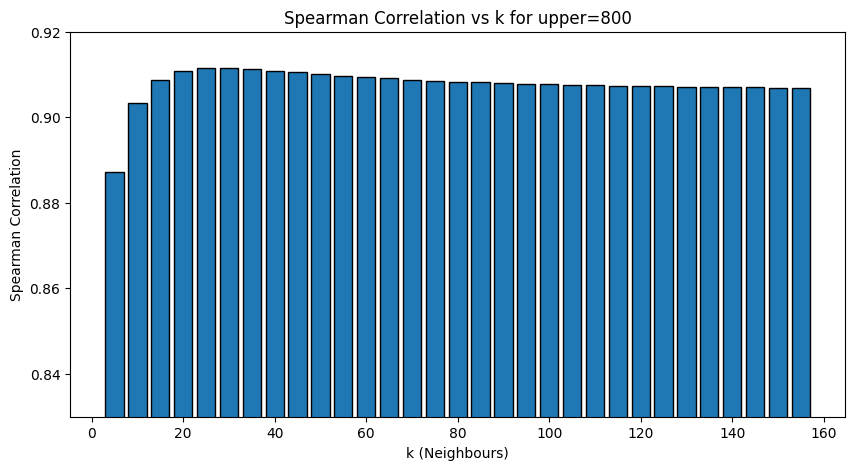

k              15.000000
correlation     0.907414
Name: 2, dtype: float64


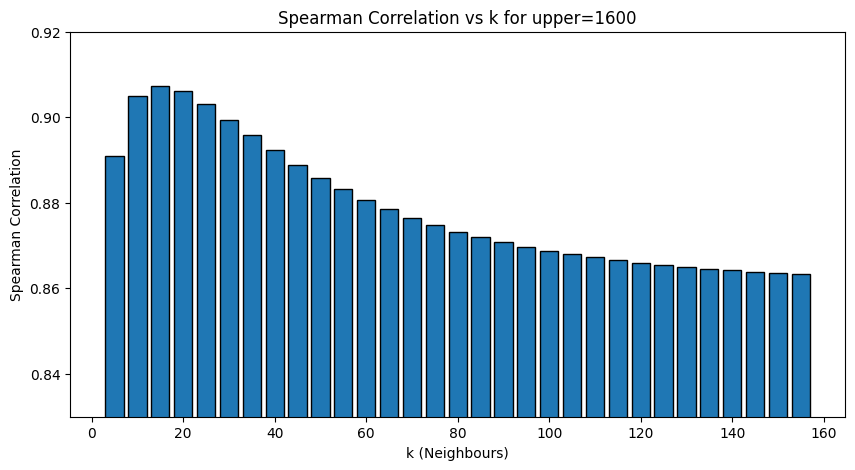

k              15.000000
correlation     0.905371
Name: 2, dtype: float64


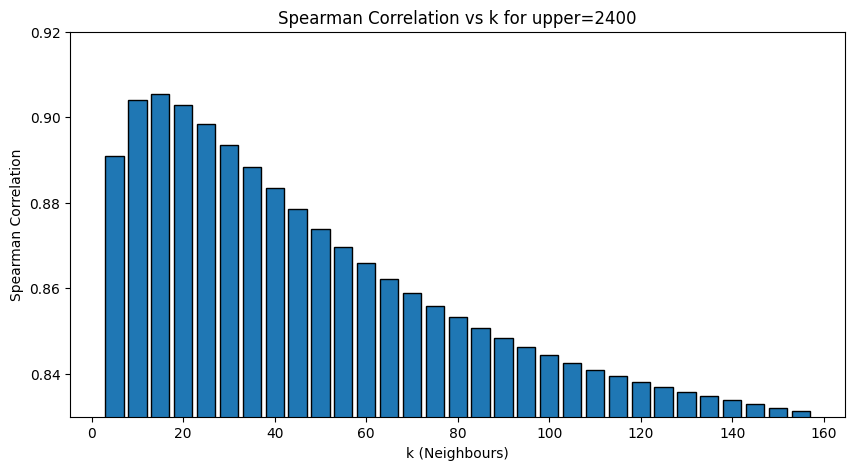

In [30]:
# List of upper values to plot histograms for
upper_values = [800, 1600, 2400]

# Loop through each upper value and plot the histogram
for upper in upper_values:
    # Read the correlation CSV
    correlation_df = pd.read_csv(f"../output/correlations/final_correlation_results{upper}.csv")

    print(correlation_df.loc[correlation_df['correlation'].idxmax()])
    
    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.bar(correlation_df['k'], correlation_df['correlation'], width=4, edgecolor='black')
    plt.xlabel('k (Neighbours)')
    plt.ylabel('Spearman Correlation')
    plt.title(f'Spearman Correlation vs k for upper={upper}')
    plt.ylim(0.83, 0.92)
    plt.show()


Since the best correlation is between the original Walkscore and the model that has an upper threshold of 800 meters and 30 nearest neighbors amenities, we choose that model to estimate the historical data.